Published on January 23, 2023 by Marília Prata, mpwolke.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#Code by by VinceVence https://www.kaggle.com/code/vencerlanz09/plant-stress-classification-using-cnn-mobilenet/notebook

# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Helper functions

In [7]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

#Load and Transform Data

In [8]:
#Code by by VinceVence https://www.kaggle.com/code/vencerlanz09/plant-stress-classification-using-cnn-mobilenet/notebook

BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [10]:
#Code by by VinceVence https://www.kaggle.com/code/vencerlanz09/plant-stress-classification-using-cnn-mobilenet/notebook

# Walk through each directory
dataset = "../input/normal-vs-military-vehicles/dataset/"
walk_through_dir(dataset)

#Deprecation Warning 

DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]

In [11]:
#pd.Series(dtype='object') No warning No need anymore

#Placing data into a Dataframe

In [12]:
#Code by by VinceVence https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

#https://www.kaggle.com/code/vencerlanz09/plant-stress-classification-using-cnn-mobilenet/notebook

image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [13]:
image_df

Empty DataFrame
Columns: [Filepath, Label]
Index: []

#Visualizing images from the dataset

In [14]:
#By Vince Vence https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

ValueError: high <= 0

#Data Preprocessing

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

#split data

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 11170 validated image filenames belonging to 2 classes.
Found 2792 validated image filenames belonging to 2 classes.
Found 3491 validated image filenames belonging to 2 classes.


#Resize Layer

In [13]:
#By Vince Vence https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2023-01-23 19:19:17.889926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:19:17.890906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:19:18.035651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:19:18.036535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 19:19:18.037383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

#Load the pretrained model

"The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:"

Batch size : 32

Epochs : 100

Input Shape : (224, 224, 3)

Output layer : 2

https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

In [14]:
#By Vince https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

# Load the pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
# Create checkpoint callback
checkpoint_path = "shell_and_pebbles_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

#EarlyStopping Callback

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

#Activation Functions

Sigmoid / Logistic Activation Function

"It is commonly used for models where we have to predict the probability as an output. Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice because of its range."

https://www.v7labs.com/blog/neural-networks-activation-functions#:~:text=Sigmoid%20%2F%20Logistic%20Activation%20Function&text=It%20is%20commonly%20used%20for,choice%20because%20of%20its%20range.

Why we use ReLU activation function in CNN?
 
"As a consequence, the usage of ReLU helps to prevent the exponential growth in the computation required to operate the neural network. If the CNN scales in size, the computational cost of adding extra ReLUs increases linearly."
https://www.baeldung.com/cs/ml-relu-dropout-layers

In [17]:
#https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='sigmoid')(x) #Original softmax

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "military_vehicles_classification"),
        checkpoint_callback,
    ]
)

2023-01-23 19:19:23.689478: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-23 19:19:23.689518: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-23 19:19:23.691859: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2023-01-23 19:19:24.153771: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-23 19:19:24.153964: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Saving TensorBoard log files to: training_logs/military_vehicles_classification/20230123-191923


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2023-01-23 19:19:24.730728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-23 19:19:28.870166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/350 [..............................] - ETA: 1:03:15 - loss: 0.9757 - accuracy: 0.3125

2023-01-23 19:19:35.720199: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-23 19:19:35.720245: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/350 [..............................] - ETA: 4:29 - loss: 0.9350 - accuracy: 0.3750   

2023-01-23 19:19:36.420168: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-23 19:19:36.421158: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-23 19:19:36.587333: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 302 callback api events and 299 activity events. 
2023-01-23 19:19:36.604645: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  3/350 [..............................] - ETA: 3:09 - loss: 0.8953 - accuracy: 0.4062

2023-01-23 19:19:36.629308: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/military_vehicles_classification/20230123-191923/train/plugins/profile/2023_01_23_19_19_36

2023-01-23 19:19:36.637898: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/military_vehicles_classification/20230123-191923/train/plugins/profile/2023_01_23_19_19_36/4015dda53030.trace.json.gz
2023-01-23 19:19:36.680938: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/military_vehicles_classification/20230123-191923/train/plugins/profile/2023_01_23_19_19_36

2023-01-23 19:19:36.688261: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to training_logs/military_vehicles_classification/20230123-191923/train/plugins/profile/2023_01_23_19_19_36/4015dda53030.memory_profile.json.gz
2023-01-23 19:19:36.689645

350/350 [==============================] - 138s 363ms/step - loss: 0.6226 - accuracy: 0.6502 - val_loss: 0.4406 - val_accuracy: 0.8632
Epoch 2/100
350/350 [==============================] - 43s 123ms/step - loss: 0.4059 - accuracy: 0.8389 - val_loss: 0.3069 - val_accuracy: 0.8954
Epoch 3/100
350/350 [==============================] - 42s 121ms/step - loss: 0.3054 - accuracy: 0.8861 - val_loss: 0.2543 - val_accuracy: 0.9112
Epoch 4/100
350/350 [==============================] - 42s 119ms/step - loss: 0.2639 - accuracy: 0.8996 - val_loss: 0.2269 - val_accuracy: 0.9201
Epoch 5/100
350/350 [==============================] - 42s 118ms/step - loss: 0.2394 - accuracy: 0.9074 - val_loss: 0.2104 - val_accuracy: 0.9266
Epoch 6/100
350/350 [==============================] - 42s 119ms/step - loss: 0.2238 - accuracy: 0.9148 - val_loss: 0.1995 - val_accuracy: 0.9302
Epoch 7/100
350/350 [==============================] - 43s 124ms/step - loss: 0.2112 - accuracy: 0.9178 - val_loss: 0.1900 - val_accura

#Visualizing loss curves

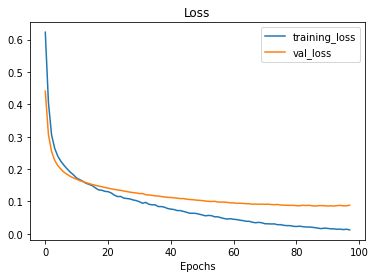

In [18]:
plot_loss_curves(history)

#Making predictions on the Test Data

In [19]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['other', 'millitary', 'other', 'millitary', 'other']


#Random Pictures

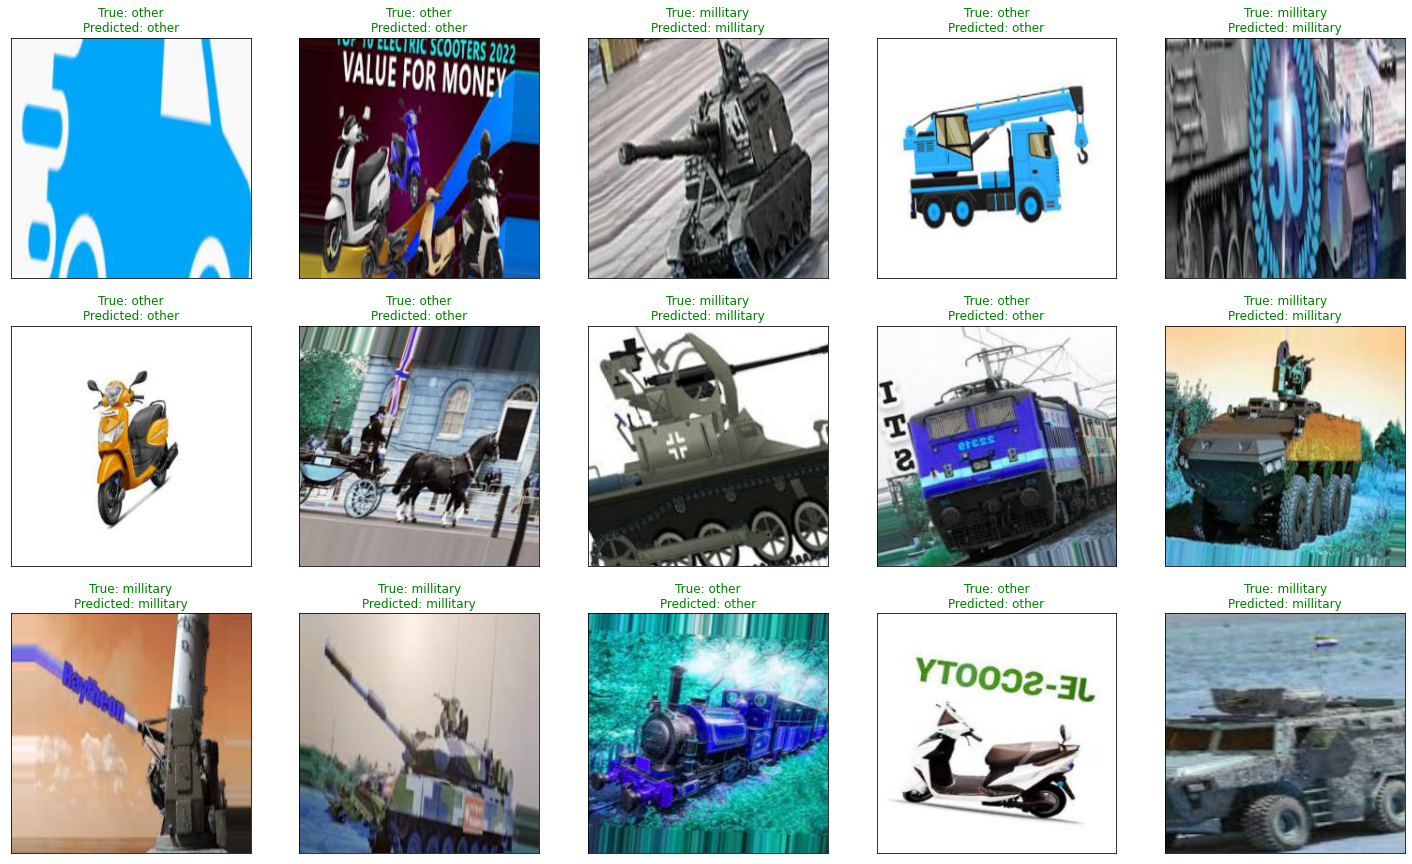

<Figure size 432x288 with 0 Axes>

In [20]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

#Plotting the Classification Reports and Confusion Matrix

In [21]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   millitary       0.97      0.96      0.97      1620
       other       0.97      0.98      0.97      1871

    accuracy                           0.97      3491
   macro avg       0.97      0.97      0.97      3491
weighted avg       0.97      0.97      0.97      3491



In [22]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
millitary      0.973209  0.964198  0.968682  1620.000000
other          0.969247  0.977018  0.973117  1871.000000
accuracy       0.971068  0.971068  0.971068     0.971068
macro avg      0.971228  0.970608  0.970900  3491.000000
weighted avg   0.971085  0.971068  0.971059  3491.000000

In [23]:
#https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

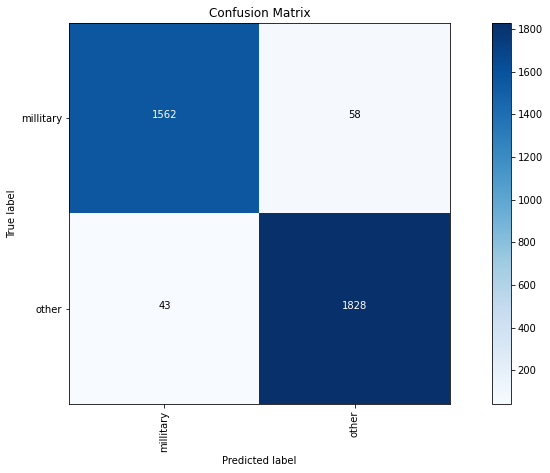

In [24]:
make_confusion_matrix(y_test, pred, list(labels.values()))

#Acknowledgements:

Vince Vence https://www.kaggle.com/code/vencerlanz09/shells-and-pebbles-classification-using-cnn